In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chi2

## CRM determination

In [55]:
ndat = 10
C = 0.1 * np.diag(np.ones(ndat))
C_inverse = np.linalg.inv(C)
n_reps = 5000
x_data = np.arange(1, 11, 1)
param_scan_vals = np.linspace(0.5, 1.5, 10)


def chi2_fit(a, y_data, fit_invcovmat):
    theory = a * x_data
    diff = (y_data - theory)
    chi2 = diff @ fit_invcovmat @ diff.T
    
    
    return chi2

mean_a = []
std_a = []

chi2_values_scan = []
chi2_values_min = []
param_best_fit = []
y_theory = []
for rep in range(n_reps):
    y_data = x_data + np.random.multivariate_normal(np.zeros(ndat), C, 1)
    result = minimize(chi2_fit, [1], args=(y_data, C_inverse))
    param_best_fit.append(result.x[0])
    y_theory.append(result.x[0] * x_data)
    chi2_values_min.append(result.fun)
    # chi2_values_scan.append([chi2_fit(a) for a in param_scan_vals])
    
param_best_fit = np.array(param_best_fit)
mean_a.append(np.mean(param_best_fit))
std_a.append(np.std(param_best_fit))
chi2_values_scan = np.array(chi2_values_scan) 
chi2_values_min = np.array(chi2_values_min)
y_theory = np.array(y_theory)
    


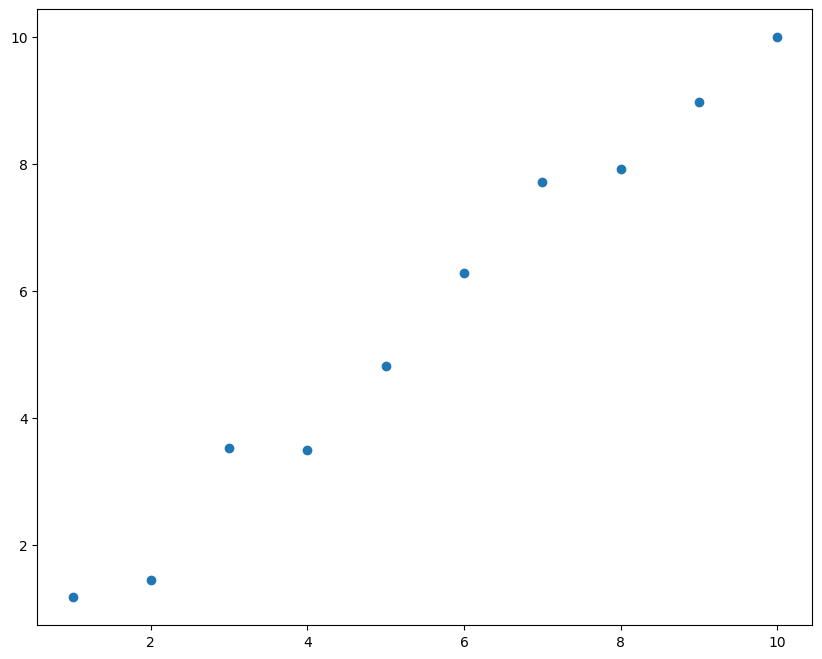

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x_data, y_data)

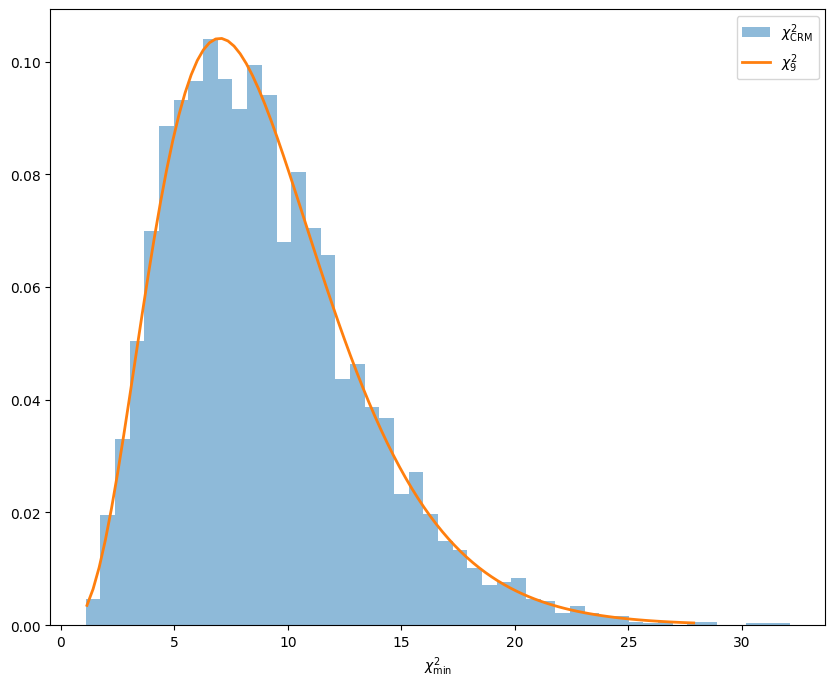

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(chi2_values_min, bins='fd', ec='k', alpha=0.5, label='$\\chi^2_{\\rm CRM}$', density=True)
# plot chi2 with n dof
df = len(x_data) - 1
x = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 100)
rv = chi2(df)
ax.plot(x, rv.pdf(x), lw=2, label='$\\chi^2_9$')
ax.set_xlabel("$\\chi^2_{\\rm min}$")
plt.legend()

In [58]:
mean_a_CRM = np.mean(param_best_fit)
std_a_CRM = np.std(param_best_fit)

print(f"CRM determination (68%): {mean_a_CRM} +/- {std_a_CRM}")

CRM determination (68%): 1.000080747470069 +/- 0.01602450813667619


## TCM determination

In [59]:
# uncertainty in the theory with 10 uncorrelated nuisances to model the stats unc
delta_a = 0.7
a_central = 0.9
a_plus = a_central + delta_a
a_min = a_central - delta_a
prior_theorypreds_plus = a_plus * x_data
prior_theorypreds_central = a_central * x_data
prior_theorypreds_minus = a_min * x_data

delta_plus = 1/ np.sqrt(2) * (prior_theorypreds_plus - prior_theorypreds_central)
delta_minus = 1 / np.sqrt(2) * (prior_theorypreds_minus - prior_theorypreds_central)

beta = np.array([delta_plus, delta_minus]).T  # shape (n_dat, 2 * n_par)
S = beta @ beta.T

invcov = np.linalg.inv(C + S)

In [60]:
# prior
step_size = np.abs(a_plus - a_central)
beta_tilde = step_size / np.sqrt(2) * np.array([[1, -1]])
S_tilde = beta_tilde @ beta_tilde.T
S_hat = beta_tilde @ beta.T


In [61]:
S_tilde

array([[0.49]])

In [62]:
y_theory_tcm = []
y_data_tcm = []
for rep in range(n_reps):
    y_data = x_data + np.random.multivariate_normal(np.zeros(ndat), C + S, 1)
    #result = minimize(chi2_fit, [1], args=(y_data,invcov))
    
    # the slope parameter is not a fitted parameter, similar to alphas in NNPDF is kept fixed to 0.118
    # TODO: no replica dependence in the theory prediction at the moment
    y_theory_tcm.append(a_central * x_data)
    y_data_tcm.append(y_data.flatten())
    
y_theory_tcm = np.array(y_theory_tcm)
y_data_tcm = np.array(y_data_tcm)
X = np.cov(y_theory_tcm.T)

In [63]:
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + S_tilde - S_hat @ invcov @ S_hat.T
delta_T_tilde = -S_hat @ invcov @ (y_theory_tcm.mean(axis=0) - y_data_tcm.mean(axis=0))
T_tilde = a_central + delta_T_tilde

print(f"TCM determination (68%): {T_tilde[0]} +/- {np.sqrt(P_tilde[0,0])}")

TCM determination (68%): 0.987427563644075 +/- 0.016112189453731617


In [64]:
print(f"CRM determination (68%): {mean_a_CRM} +/- {std_a_CRM}")

CRM determination (68%): 1.000080747470069 +/- 0.01602450813667619


In [65]:
S_hat @ invcov @ X @ invcov @ S_hat.T

array([[1.74161851e-28]])

In [66]:
S_hat @ invcov @ S_hat.T

array([[0.4897404]])

In [67]:
S_tilde

array([[0.49]])